# SLT-CE-2: Sampling

In this coding exercise we will test various Markov Chain Monte Carlo (MCMC) sampling procedures [1] introduced during the tutorial session. We will first tackle the image reconstruction problem followed by the traveling salesman problem.

## Task (image reconstruction problem)


Given a noisy [binary image](https://en.wikipedia.org/wiki/Binary_image) one needs to recover the original through denoising. To do so we will use the prototypical [Ising model](https://en.wikipedia.org/wiki/Ising_model) from physics as explained in section 8.3.3 of [2]. An undirected graphical model is designed to model (i) the adherence of the reconstruction to the observed noisy image and (ii) the correlation between neighboring pixels. We are interested in recovering a single image, the most likely one, with respect to the underlying distribution i.e. we do MAP inference to discover the peak of the posterior distribution $p(image\_reconstruction | noisy\_observation)$.


### References 
[0] [SLT Tutorial 3 on Sampling](https://ml2.inf.ethz.ch/courses/slt/tutorials/tutorial03-sampling.pdf)

[1] http://www.cs.princeton.edu/courses/archive/spr06/cos598C/papers/AndrieuFreitasDoucetJordan2003.pdf

[2] Bishop, Christopher M. "Pattern Recognition and Machine Learning." (2006).

## Model

Given a noisy, binary image $y=(y_1,\dots,y_n)$ where $y_i\in\{\pm1\}$ is the value of the i-th pixel, the Ising model tries to find a denoised image $x=(x_1,\dots,x_n)$ by minimizing the following energy function:

$$E(x|y) = - \frac{\beta}{2} \sum_{i} \frac{x_i}{\lvert N_i\rvert}\sum_{j \in N_i} x_j - \mu \sum_{i} x_i y_i$$

where $N_i$ is the set of neighbors of pixel $i$. For a 2D image the pixel neighbourhood $N_i$ usually involves $\lvert N_i\rvert=$ 4 or 8 surrounding pixels. In this exercise we consider only the 4 pixel neigbourhood (up, down, left and right pixels). The undirected probabilistic graphical model from where the energy function $E(x|y)$ is derived is explained in more detail in [2].

 <h2> Setup </h2>

We start by importing necessary python packages.

In [34]:
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import time

from skimage.transform import resize
from scipy.signal import fftconvolve
from sklearn.metrics import hamming_loss

from scipy.optimize import minimize_scalar
from multiprocessing import cpu_count
from pathos.multiprocessing import ProcessingPool as Pool

import warnings
warnings.filterwarnings('ignore')

In [35]:
def flower(size=None, p=0.3):
    """Load image data for denoising
    
    Args:
        size (tuple): image size, default (300,300)
        p (float): noise fraction in [0,1]
        
    Returns:
        noisy: noisy image
        img: ground truth image
    """
    img = mpimg.imread("flower.png") # Load image
    
    # Binarize image
    img[img > 0.5] = 1
    img[img <= 0.5] = -1
    
    # Resize image 
    if size is not None:
        img = resize(img, size)
        img[img > 0] = 1
        img[img <= 0] = -1
    
    np.random.seed(13)

    flip = np.random.choice([-1, 1], size=img.shape, p=[p, 1-p])

    noisy = flip * img
    
    return noisy, img

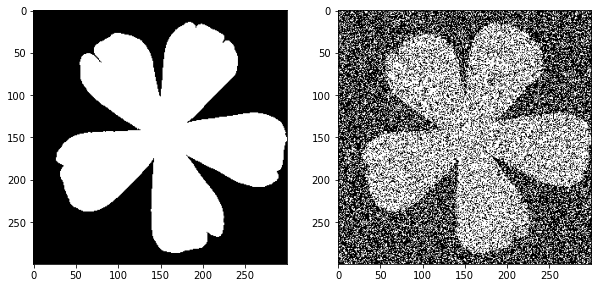

In [36]:
noisy, img = flower()

plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(img, cmap='gray')
plt.subplot(122)
plt.imshow(noisy,cmap='gray')
plt.show()

<h2 style="background-color:#f0b375;">
Section 4.0 
<span style=font-size:50%> Complete all problems in this section to get a pass on this exercise. </span>
</h2>

<p style="background-color:#adebad;">
Shortly describe the following sampling procedures, and provide the key formulas. See <a href="https://medium.com/ibm-data-science-experience/markdown-for-jupyter-notebooks-cheatsheet-386c05aeebed">markdown cheatsheet</a> for text editing.</p>

- **Metropolis**: The Metropolis algorighm is the original algorighm, from which Hastings later created the generalized Metropolis-Hastings algorithm. The algorithm requires a symmetric proposal distribution $q(c|c') = q(c'|c)$ for $c,c' \in C$. This simplifies the acceptance probability for $c'$ to $A(c,c') = min\{ 1, \frac{p(c')}{p(c)} \}$. A simple example is a random walk that uses the gaussian distribution for the proposal.

- **Metropolis-Hastings**: The Metropolis–Hastings (MH) algorithm is a Markov chain Monte Carlo (MCMC) method for sampling from probability distributions from which direct sampling is difficult. Monte Carlo is a generic term for defining methods using random sampling to solve problems. On the contrast a MArkov chain is a sequential model that satisfies the Markov property. That property results in indepenant past and future given the present. 
In MH we first choose an arbitrary sample $x_0$ and generate new samples $x_t$ by conditioning on the sample from the preceding step of the iteration, $x_{t-1}$, and build a Markov chain. In every iteration we generate a candidate for the new sample by picking an $x'$ from a proposal distribution $q(x'|x_t)$. Then, we calculate the acceptance probability for the candidate sample: $A(x_t,x') = min\{ 1, \frac{p(x')q(x_t|x')}{p(x_t)q(x'|x_t)} \}$. We set $x_{t+1} = x'$ with probability $A(x_t,x')$ or leave it as $x_{t+1} = x_t$ otherwise. The choice of the proposal distribution does not alter the convergence guarantee of the MH algorithm. Though it is very crucial as it directly affects the "accepted samples are generation" speed. MH is most efficient when the assumed proposal distribution matches the desired target distribution.

- **Simulated Annealing**: Simulated Annealing is used for approximating the global optimum of a given function and is a variant of the MH algorithm. It uses a non-homogeneous Markov chain to generate samples. Therefore the invariant distributions at each iteration do not equate to $p(x)$ but rather to $p_t(x) \propto p^{1/T_t}(x)$, where $T_t$ is the "temperature" at iteration $t$, where $T_0 = 1$. Similarly, replacing the invariant probabilities in the above, general formula yields an acceptance probability $A(x_t,x') = min\{ 1, \frac{p^{1/T_t}(x')q(x_t|x')}{p^{1/T_t}(x_t)q(x'|x_t)} \}$. There are many "cooling schedules" to update the temperature at each iteration. 

For our purposes exponential schedule produced satisfactory results and other explored schedules failed to deliver better results, so we only illustrate the exponential schedule below. Simulated annealing can be very useful for the global optimization tasks, at it may escape being stuck in local optima. The overall procedure is based on the annealing process in material sciences where the subject material is cooled carefully according to a schedule to produce a structure with desired atttributes.

<p style="background-color:#adebad;">
    Implement the energy function introduced in the model section of the notebook.<br>
    <b> (!)</b> Deliberately implement a naive solution, which explicitly performs (nested) loops to compute the sums. 
    </p>

In [37]:
def energy(img_noisy_observation, img_estimate, beta=2.5, mu=1):
    """Compute the energy for given estimate 'img_estimate' which
    is our vector x in the original model, with respect to the 
    observation 'img_noisy_observation', which corresponds to the vector y in the model.

    Args:
        img_estimate (np.ndarray): estimated image matrix
        img_noisy_observation (np.ndarray): noisy image matrix

    Returns:
        energy (float): energy of the estimate given observation
    """
    height = img_estimate.shape[0]
    width = img_estimate.shape[1]
    
    E = 0
    N_i = 4
    tmp = beta/(2*N_i)
    for i in range(height):
        for j in range(width):
            if (i-1 > -1): E -= img_estimate[i-1, j]*img_estimate[i, j]*tmp      # down
            if (j-1 > -1): E -= img_estimate[i, j-1]*img_estimate[i, j]*tmp      # left
            if (i+1 < height): E -= img_estimate[i+1, j]*img_estimate[i, j]*tmp  # up
            if (j+1 < width): E -= img_estimate[i, j+1]*img_estimate[i, j]*tmp   # right
            E -= img_estimate[i, j]*img_noisy_observation[i, j]*mu

    return E 

<p style="background-color:#adebad;">Make sure to get the correct result:</p>

In [38]:
assert np.isclose(energy(*flower()), -145700.75)

<p style="background-color:#adebad;">Implement metropolis sampling.<br>
<b>(!)</b> Deliberately implement a naive solution, which loops over each pixel, attempts a flip, measures the energy before and after, and then decides whether to accept the flip, or not. Use the naive energy function from before.
</p>

In [39]:
def metropolis(img_noisy_observation, epochs, T=1):
    """Metropolis sampling
    
    For each epoch, loop over every pixel and attempt flip using energy.

    Args:
        img_noisy_observation (np.ndarray): noisy image matrix
        epochs (int): number of rounds over all pixels
        T (float): Temperature of the simulation

    Returns:
        img_estimate (np.ndarray): reconstucted image estimate
        energies (np.ndarray): energy after each epoch
    """
    np.random.seed(7) # Always set the random seed to a lucky number
    
    height = img_noisy_observation.shape[0]
    width = img_noisy_observation.shape[1]
    n_pixels = height * width
    
    noisy_img = img_noisy_observation.copy()
    estimate = img_noisy_observation.copy()
    
    energies = []
    for e in range(epochs):
        
        if e == 0:
            energies.append(energy(noisy_img, estimate))

        energy_before = None
        for cnt, idx in enumerate(np.random.permutation(n_pixels)):
            print("Finished {:6.2f}% of epoch {}".format(cnt/n_pixels * 100, e+1), end="\r")
            
            if energy_before is None: energy_before = energy(noisy_img, estimate)
            idx_ = np.unravel_index(idx, (height, width))
            flipped_noisy_img = estimate.copy()
            flipped_noisy_img[idx_] *= -1
            energy_after = energy(noisy_img, flipped_noisy_img)
            if min(np.exp((energy_before - energy_after)/T),1) > np.random.random():
                estimate = flipped_noisy_img
                energy_before = energy_after

        energies.append(energy_before)
        
    return estimate, np.asarray(energies)

<p style="background-color:#adebad;">
    Evaluate your implemented metropolis algorithm, using the provided evaluation function.<br>
    The energy should decrease over epochs. The reconstructed image should be a denoised version of the noisy image.
    </p>

In [40]:
def evaluate_ising(method, img_noisy_observation, img_original, epochs=1, T=1, surpress=False):
    """ Given a sampling method, we will run the sampling procedure 
    for the specifed number of epochs. We measure time and reconstruction
    efficiency.

    Args:
        method (function pointer): sampling method
        img_noisy_observation (np.ndarray): noisy image matrix
        img_original (np.ndarray): original image matrix
        epochs (int): number of epochs to run the sampling, one epoch means going through all pixels once.
        T (float): The positive temperature of the simulation
    """

    start_time = time.time()
    img_estimate, energies = method(img_noisy_observation, epochs, T)
    execution_time = time.time() - start_time

    if not surpress:
        f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))

        ax1.plot(energies, marker="x")
        ax1.set_xlabel('epoch')
        ax1.set_ylabel('energy')

        ax2.imshow(img_estimate, cmap='gray')
        ax2.set_title('Reconstruction')
        ax2.get_xaxis().set_visible(False)
        ax2.get_yaxis().set_visible(False)

        ax3.imshow(img_noisy_observation, cmap='gray')
        ax3.set_title('Input')
        ax3.get_xaxis().set_visible(False)
        ax3.get_yaxis().set_visible(False)

        plt.suptitle("{} updates per second".format(int(img_original.size*epochs/execution_time)))

        plt.show()
    
    return energies[-1], hamming_loss(y_pred=img_estimate.flatten(), y_true=img_original.flatten())

<p style="background-color:#adebad;">
    The naive implementation is incredibly slow, so we use a downsampled image for evaluation.
</p>

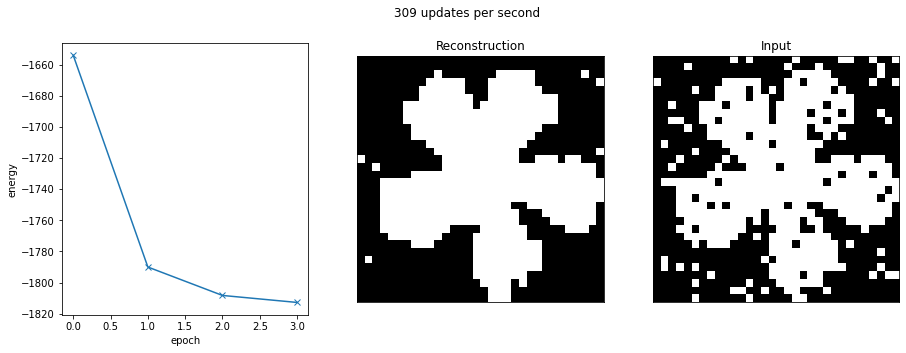

In [41]:
E_metro = evaluate_ising(metropolis, *flower(size=(32,32), p=0.1), epochs=3)

<h2 style="background-color:#f0b375;">
Section 4.5 
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 4.5 </span>
</h2>

<p style="background-color:#adebad;">
We are now considering a different problem. We want to solve the <a href="https://en.wikipedia.org/wiki/Travelling_salesman_problem">traveling salesman problem</a> for N=532 major cities in the USA.
</p>

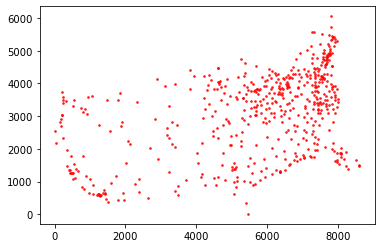

In [42]:
coordinates = pd.read_csv("cities.csv", names=['x', 'y'], sep=';', index_col=False)
coordinates = np.asarray(coordinates)  # Nx2 array containing the coordiantes of the cities
plt.scatter(coordinates[:,0], coordinates[:,1], s=3, c="r", alpha=0.75)
plt.show()

<p style="background-color:#adebad;">
Implement the distance function for the TSP:
</p>

In [43]:
def distance(coordinates, route=None):
    """Calculate travel distance.
    
    If no route is given, assumes that coordinates are travelled in order,
    starting at the first entry, and connecting the last entry again with the first.
    
    Args:
        coordinates (np.ndarray): route coordinates (assume in units of meters)
        route: permutation of coordinate order
        
    Returns:
        float: traveled distance in units of kilometers
    """
     
    if route is not None:
        coordinates = coordinates[route]
    coordinates = np.append(coordinates, [coordinates[0]], axis=0) 
    return np.sum(np.sqrt(np.sum(np.square(np.diff(coordinates, axis=0)), axis=1)))/1000

<p style="background-color:#adebad;">
Make sure it returns the correct value:
</p>

In [44]:
assert np.isclose(distance(coordinates), 978.3514183630234)

In [45]:
def evaluate_tsp(method, coordinates, epochs=1):
    """Evaluate sampling method on coordinates
    
    Args:
        method (function pointer): sampling method
        coordinates (np.ndarray): city coordinates, shape Nx2
        epochs (int): number of epochs to run the sampling
    """
    np.random.seed(7)
    N = coordinates.shape[0]
    route = np.random.permutation(N)
 
    start_time = time.time()
    route, distances = method(coordinates, route, epochs)
    execution_time = time.time() - start_time

    if not (np.sort(route) == range(N)).all():
        raise ValueError("Returned route is not valid!")

    x, y = coordinates[route, 0], coordinates[route, 1]
    
    plt.figure(figsize=(15, 5))
    
    plt.subplot(121)
    plt.plot(distances, marker="o", markersize=3)
    plt.plot([0, len(distances)], [27686/1000,27686/1000], c="green") # best known solution
    plt.grid(axis="y")
    
    plt.subplot(122, xticks=[], yticks=[])
    plt.plot(x, y, alpha=0.5, c="blue", marker="o", markerfacecolor="red", markersize=3, linewidth=1)
    plt.plot([x[0], x[-1]], [y[0], y[-1]], alpha=0.5, c="blue", linewidth=1)
    
    plt.show()

<p style="background-color:#adebad;">
First, solve the traveling salesman problem with metropolis, and then with simulated annealing. <br>
We consider all permutations of $(1,\dots,N)$ as the solution space, so one route corresponds to one permutation. <br>
As proposals use transpositions instead of pixel flips. <br>
More precisely, pick a random index $i$, and exchange it with its successor, i.e. $(x_1,\dots,x_i, x_{i+1},\dots,x_N) \rightarrow (x_1,\dots,x_{i+1}, x_{i},\dots,x_N)$.<br>
    Keep in mind, that TSP goes in a cycle, so the successor of N is 1.
</p>

In [46]:
def metropolis_tsp(coordinates, route=None, epochs=1, T=1):
    """Metropolis for TSP

    Args:
        coordinates (np.ndarray): initial route consisting of coordinates
        epochs (int): number of loops through all cities.
        T (float): Temperature of simulation

    Returns:
        route (np.ndarray): optimized route
        distances (np.ndarray): travel distance after each epoch
    """
    np.random.seed(7)
    
    N = coordinates.shape[0]
    
    if route is None:
        route = np.random.permutation(N)
    
    distances = []
    distances.append(distance(coordinates, route))
    
    
    for e in range(epochs):
        print("Finished epoch {}".format(e+1), end="\r", flush=True)
        distance_before = None
        for idx in np.random.permutation(N):
            if distance_before is None: distance_before = distances[-1]
            route_new = route.copy()
            route_new[[idx, (idx+1)%N]] = route_new[[(idx+1)%N, idx]]
            distance_after = distance(coordinates, route=route_new)
            if min(np.exp((distance_before - distance_after)/T), 1) > np.random.random():
                route = route_new
                distance_before = distance_after
                
        distances.append(distance_before)

    return np.asarray(route), np.asarray(distances)

<p style="background-color:#adebad;">
Evaluate your metropolis algorithm for the traveling salesman problem.
</p>

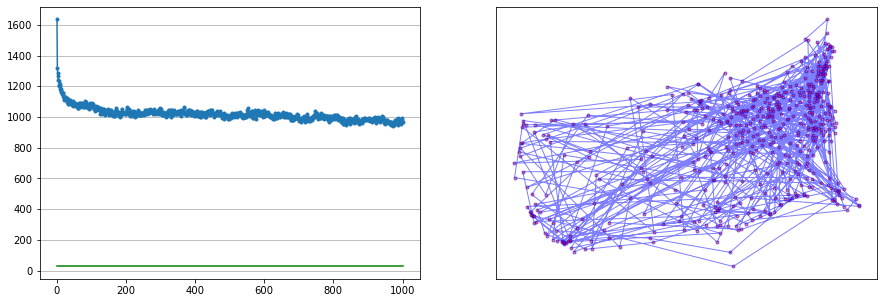

In [47]:
evaluate_tsp(metropolis_tsp, coordinates, epochs=1000)

In [48]:
def simulated_annealing(coordinates, route=None, epochs=1, T=20.0, eta=0.995):
    """Simulated Annealing for TSP

    T(n) = T * eta**n

    Args:
        coordinates (np.ndarray): initial route consisting of coordinates
        route (array): inital route
        epochs (int): number of loops through all cities.
        T (float): Initial temperature
        eta (float): Exponential cooling rate

    Returns:
        route (np.ndarray): optimized route
        distances (np.ndarray): travel distance after each epoch
    """
    np.random.seed(7)
    
    N = coordinates.shape[0]
    
    if route is None:
        route = np.random.permutation(N)
    
    distances = []
    distances.append(distance(coordinates, route))

    for e in range(epochs):
        print("Finished epoch {}".format(e+1), end="\r", flush=True)
        T *= eta
        distance_before = None
        for idx in np.random.permutation(N):
            if distance_before is None: distance_before = distances[-1]
            route_new = route.copy()
            route_new[[idx, (idx+1)%N]] = route_new[[(idx+1)%N, idx]]
            distance_after = distance(coordinates, route=route_new)
            if min(np.exp((distance_before - distance_after)/T),1) > np.random.random():
                route = route_new
                distance_before = distance_after 
         
        distances.append(distance_before)

    return np.asarray(route), np.asarray(distances)

<p style="background-color:#adebad;">
Evaluate your simulated annealing algorithm for the traveling salesman problem.
</p>

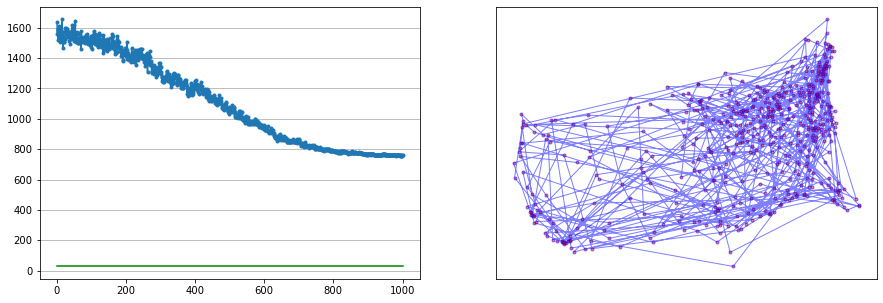

In [49]:
evaluate_tsp(simulated_annealing, coordinates, epochs=1000)

<h2 style="background-color:#f0b375;">
Section 5.0 
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 5.0 </span>
</h2>

<p style="background-color:#adebad;">
    Optimize the calculation of the naive metropolis for the Ising problem by taking into account that the energy change caused by a single flip depends only on the affected pixel's value, and its neighborhood.<br>
    More precisely, implement the function local_energy_change, and use it in the method local_metropolis.
</p>

In [50]:
def local_energy_change(noisy, estimate, i, j, beta, mu):
    """
    
    Local energy difference between unflipped and flipped pixel i,j 
    
    Args:
        noisy: noisy reference image
        estimate: current denoising estimate
        i,j: Position of pixel
    
    Returns:
        float: local energy difference when pixel i,j is flipped 
    """
    height = estimate.shape[0]
    width = estimate.shape[1]
    
    dE = 0
    N_i = 4
    tmp = -beta/(2*N_i)
    
    if (i-1 > -1): dE += estimate[i-1, j]      # down
    if (j-1 > -1): dE += estimate[i, j-1]      # left
    if (i+1 < height): dE += estimate[i+1, j]  # up
    if (j+1 < width): dE += estimate[i, j+1]   # right
    dE *= tmp
    dE *= 2    # Don't forget the changed x_j from the neighbors!
    dE -= noisy[i, j]*mu
    dE *= -2*estimate[i, j]
    
    return dE


def local_metropolis(img_noisy_observation, epochs, T=1, beta=2.5, mu=1):
    """Metropolis sampling
    
    For each epoch, loop over every pixel and attempt flip using local_energy_change 

    Args:
        img_noisy_observation (np.ndarray): noisy image matrix
        epochs (int): number of rounds over all pixels
        T (float): Temperature of simulation

    Returns:
        img_estimate (np.ndarray): reconstucted image estimate
        energies (np.ndarray): energy after each epoch
    """
    np.random.seed(7) # Always set the random seed to a lucky number
    
    height = img_noisy_observation.shape[0]
    width = img_noisy_observation.shape[1]
    n_pixels = height * width
    
    noisy_img = img_noisy_observation.copy()
    estimate = img_noisy_observation.copy()
    
    energies = []
    for e in range(epochs):
        
        if e == 0:
            energies.append(energy(noisy_img, estimate))
            
        for cnt, pix in enumerate(np.random.permutation(n_pixels)):
            i, j = np.unravel_index(pix, (height, width))
            if min(np.exp(-local_energy_change(noisy_img, estimate, i, j, beta, mu)/T),1) > np.random.random():
                estimate[i, j] *= -1
        
        print("Finished epoch {}".format(e+1), end="\r")
        energies.append(energy(noisy_img, estimate))
        
    return estimate, np.asarray(energies)

<p style="background-color:#adebad;">
    We run two evaluations, one for the small image, and one on the full image.
    </p>

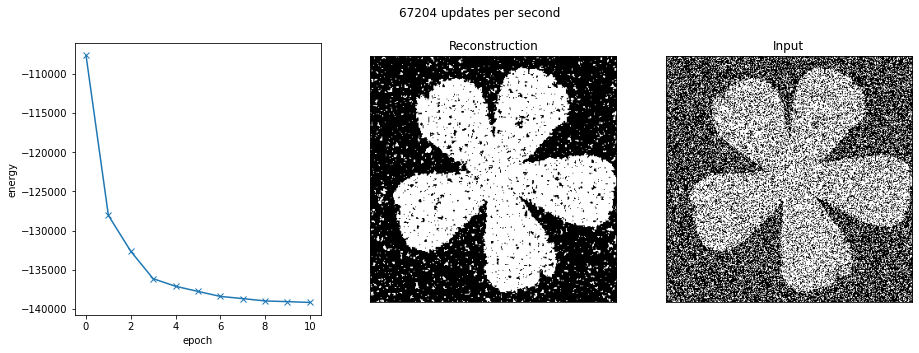

(-139178.75, 0.0736)

In [51]:
E_local = evaluate_ising(local_metropolis, *flower(size=(32,32), p=0.1), epochs=3, surpress=True);
evaluate_ising(local_metropolis, *flower(), epochs=10)

<p style="background-color:#adebad;">
    Make sure, metropolis and local_metropolis are equivalent:
    </p>

In [52]:
assert E_metro == E_local

<h2 style="background-color:#f0b375;">
Section 5.5 
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 5.5 </span>
</h2>

<p style="background-color:#adebad;">
    We can speed up metropolis for the Ising model even further by using vectorized operations, i.e. using operations on arrays instead of looping over pixels.<br>
    Implement checkerboard_metropolis, which alternatingly updates two independent sub-grids at once.
    Your final code must have only one for-loop, namely over epochs (not counting the loop over the two grids). Use fftconvolve to compute the neighborhood term of the energy difference.
    </p>

In [53]:
def checkerboard_energy_change(noisy_img, estimate, grid, beta, mu):
    """Compute energy change when flipping pixels in grid
    
    When using the 4-neighborhood, a 2D image can be separated in two
    independent grids, hence the name checkerboard.
    All the pixels in one grid can be updated simultaneously, because they
    are independent. Using this property, we can improve computational
    efficiency by using vectorized operations instead of loops.
    
    Args:
        noisy_img: Noisy reference image
        estimate: Current image reconstruction
        grid: Flat array or list of grid indices.
    
    Returns:
        numpy.array: Energy change for each pixel in grid,
            same size as grid.
    
    """
    
    N_i = 4
    tmp = -beta/(2*N_i)
    dE = fftconvolve(estimate, [[0,1,0], [1,0,1], [0,1,0]], mode='same')
    dE *= tmp
    dE *= 2
    dE -= noisy_img*mu
    dE *= -2*estimate
    
    return dE[grid[:,0], grid[:,1]]

In [54]:
def checkerboard_metropolis(img_noisy_observation, epochs=1, T=1, beta=2.5, mu=1):
    """Metropolis sampling
    
    Alternatingly update two independent grids

    Args:
        img_noisy_observation (np.ndarray): noisy image matrix
        epochs (int): number of rounds over all pixels

    Returns:
        img_estimate (np.ndarray): reconstucted image estimate
        energies (np.ndarray): energy after each epoch
    """
    np.random.seed(7) # Always set the random seed to a lucky number

    n_pixels = img_noisy_observation.size
    
    noisy_img = img_noisy_observation.copy()
    estimate = img_noisy_observation.copy()
    
    grid_mask = np.zeros(np.shape(noisy_img))
    grid_mask[::2, 1::2] = 1
    grid_mask[1::2, ::2] = 1
    grids = np.asarray([np.argwhere(grid_mask == 1), np.argwhere(grid_mask == 0)])
    grid_len = grids.shape[1]
    
    energies = []
    for e in range(epochs):

        if e == 0:
            energies.append(energy(noisy_img, estimate))
        
        for grid in grids:
            dE = checkerboard_energy_change(noisy_img, estimate, grid, beta, mu)
            print(dE)
            rnd = np.random.random(size=grid_len)
            idx_bool = np.minimum(np.exp(-dE/T),1) > rnd
            estimate[grid[idx_bool][:, 0], grid[idx_bool][:, 1]] *= -1  
            
        print("Finished epoch {}".format(e+1), end="\r")
        energies.append(energy(noisy_img, estimate))
        
    return estimate, np.asarray(energies)

<p style="background-color:#adebad;">
    Run the checkerboard_metropolis:
    </p>

[-1.75  5.75  3.25 ...  3.25  5.75  5.75]
[4.5  5.75 5.75 ... 3.25 5.75 4.5 ]
[1.75 5.75 5.75 ... 0.75 5.75 5.75]
[2.   3.25 5.75 ... 3.25 5.75 2.  ]
[-1.75  5.75  5.75 ...  3.25  5.75  5.75]
[4.5  5.75 5.75 ... 0.75 3.25 4.5 ]
[1.75 5.75 5.75 ... 0.75 5.75 5.75]
[4.5  5.75 5.75 ... 3.25 5.75 4.5 ]
[1.75 5.75 5.75 ... 0.75 5.75 5.75]
[4.5  5.75 5.75 ... 3.25 5.75 4.5 ]
[1.75 5.75 3.25 ... 3.25 5.75 5.75]
[4.5  5.75 3.25 ... 0.75 5.75 2.  ]
[1.75 3.25 0.75 ... 3.25 5.75 3.25]
[ 4.5   5.75 -5.75 ...  3.25  5.75 -2.  ]
[1.75 5.75 5.75 ... 0.75 5.75 5.75]
[4.5  5.75 5.75 ... 0.75 5.75 4.5 ]
[1.75 5.75 5.75 ... 3.25 5.75 5.75]
[4.5  5.75 5.75 ... 3.25 5.75 2.  ]
[1.75 5.75 3.25 ... 3.25 5.75 3.25]
[ 4.5   5.75  0.75 ...  0.75  5.75 -4.5 ]


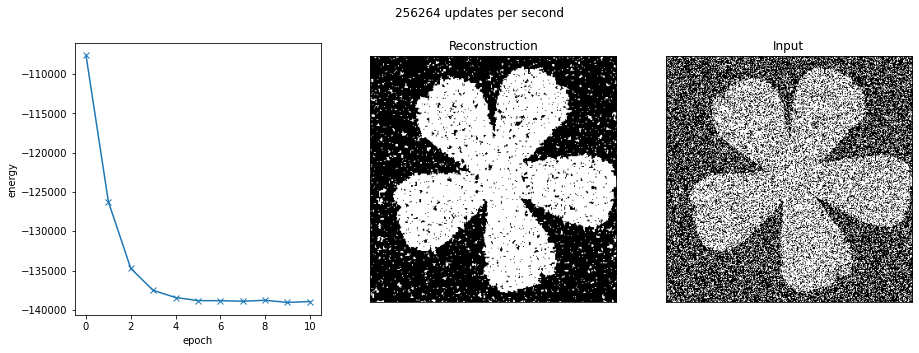

(-138947.75, 0.07227777777777777)

In [55]:
evaluate_ising(checkerboard_metropolis, *flower(), epochs=10)

<p style="background-color:#adebad;">
    Run the experiment below, and explain the observed behavior!
    </p>

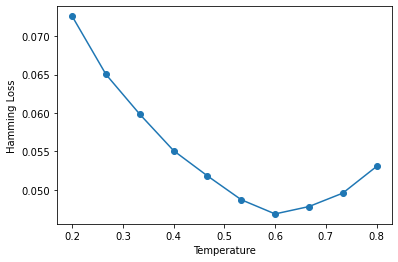

In [411]:
Trange = np.linspace(0.2,0.8,10)
loss = [evaluate_ising(checkerboard_metropolis, *flower(), epochs=10, T=T, surpress=True)[1]
         for T in np.linspace(0.2,0.8,10)]

plt.plot(Trange, loss, marker="o")
plt.ylabel("Hamming Loss")
plt.xlabel("Temperature")
plt.show()

**Fact from formula:** With a large $T$ it is more likely to accept the proposed change and vice versa.  
**Explanation:** This seems to be the optimal value curve of $T$. For small $T$, we seem stuck at a local minimum and thus with an unideal big loss (kinda like exploitation in RL). With increasing $T$, we are more susceptive to change and eventually find a better local minima (kinda like exploration in RL). That being said, one has to find a optimal balance. Which means with a $T$ too large, the decision to accept a change which affects the Loss negatively (it increases the loss) is more likely. Therefore the increase in Loss at $T > 0.6$. 

<p style="background-color:#adebad;">
Run the experiment below, and explain the observed behavior!
</p>

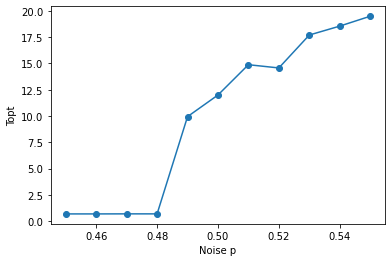

In [57]:
# 1. Function seemed not to find any functions. So I copied all neccessary into find_Topt -> working
#    Probably a problem with Windows, jupyter and multiprocessing (pathos)
# 2. I don't want my PC to freeze, so I ran it with cpu_count()-1

def find_Topt(p):
    import matplotlib.image as mpimg
    import numpy as np
    import pandas as pd
    import matplotlib.pylab as plt
    import time

    from skimage.transform import resize
    from scipy.signal import fftconvolve
    from sklearn.metrics import hamming_loss

    from scipy.optimize import minimize_scalar
    from multiprocessing import cpu_count
    from pathos.multiprocessing import ProcessingPool as Pool

    import warnings
    warnings.filterwarnings('ignore')
    
    def flower(size=None, p=0.3):
        """Load image data for denoising

        Args:
            size (tuple): image size, default (300,300)
            p (float): noise fraction in [0,1]

        Returns:
            noisy: noisy image
            img: ground truth image
        """
        img = mpimg.imread("flower.png") # Load image

        # Binarize image
        img[img > 0.5] = 1
        img[img <= 0.5] = -1

        # Resize image 
        if size is not None:
            img = resize(img, size)
            img[img > 0] = 1
            img[img <= 0] = -1

        np.random.seed(13)

        flip = np.random.choice([-1, 1], size=img.shape, p=[p, 1-p])

        noisy = flip * img

        return noisy, img
    
    def energy(img_noisy_observation, img_estimate, beta=2.5, mu=1):
        """Compute the energy for given estimate 'img_estimate' which
        is our vector x in the original model, with respect to the 
        observation 'img_noisy_observation', which corresponds to the vector y in the model.

        Args:
            img_estimate (np.ndarray): estimated image matrix
            img_noisy_observation (np.ndarray): noisy image matrix

        Returns:
            energy (float): energy of the estimate given observation
        """
        height = img_estimate.shape[0]
        width = img_estimate.shape[1]

        E = 0
        N_i = 4
        tmp = beta/(2*N_i)
        for i in range(height):
            for j in range(width):
                if (i-1 > -1): E -= img_estimate[i-1, j]*img_estimate[i, j]*tmp      # down
                if (j-1 > -1): E -= img_estimate[i, j-1]*img_estimate[i, j]*tmp      # left
                if (i+1 < height): E -= img_estimate[i+1, j]*img_estimate[i, j]*tmp  # up
                if (j+1 < width): E -= img_estimate[i, j+1]*img_estimate[i, j]*tmp   # right
                E -= img_estimate[i, j]*img_noisy_observation[i, j]*mu

        return E 
    
    def evaluate_ising(method, img_noisy_observation, img_original, epochs=1, T=1, surpress=False):
        """ Given a sampling method, we will run the sampling procedure 
        for the specifed number of epochs. We measure time and reconstruction
        efficiency.

        Args:
            method (function pointer): sampling method
            img_noisy_observation (np.ndarray): noisy image matrix
            img_original (np.ndarray): original image matrix
            epochs (int): number of epochs to run the sampling, one epoch means going through all pixels once.
            T (float): The positive temperature of the simulation
        """

        start_time = time.time()
        img_estimate, energies = method(img_noisy_observation, epochs, T)
        execution_time = time.time() - start_time

        if not surpress:
            f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))

            ax1.plot(energies, marker="x")
            ax1.set_xlabel('epoch')
            ax1.set_ylabel('energy')

            ax2.imshow(img_estimate, cmap='gray')
            ax2.set_title('Reconstruction')
            ax2.get_xaxis().set_visible(False)
            ax2.get_yaxis().set_visible(False)

            ax3.imshow(img_noisy_observation, cmap='gray')
            ax3.set_title('Input')
            ax3.get_xaxis().set_visible(False)
            ax3.get_yaxis().set_visible(False)

            plt.suptitle("{} updates per second".format(int(img_original.size*epochs/execution_time)))

            plt.show()

        return energies[-1], hamming_loss(y_pred=img_estimate.flatten(), y_true=img_original.flatten())
    
    def checkerboard_energy_change(noisy_img, estimate, grid, beta, mu):
        """Compute energy change when flipping pixels in grid

        When using the 4-neighborhood, a 2D image can be separated in two
        independent grids, hence the name checkerboard.
        All the pixels in one grid can be updated simultaneously, because they
        are independent. Using this property, we can improve computational
        efficiency by using vectorized operations instead of loops.

        Args:
            noisy_img: Noisy reference image
            estimate: Current image reconstruction
            grid: Flat array or list of grid indices.

        Returns:
            numpy.array: Energy change for each pixel in grid,
                same size as grid.

        """

        N_i = 4
        tmp = -beta/(2*N_i)
        dE = fftconvolve(estimate, [[0,1,0], [1,0,1], [0,1,0]], mode='same')
        dE *= tmp
        dE *= 2
        dE -= noisy_img*mu
        dE *= -2*estimate

        return dE[grid[:,0], grid[:,1]]
    
    def checkerboard_metropolis(img_noisy_observation, epochs=1, T=1, beta=2.5, mu=1):
        """Metropolis sampling

        Alternatingly update two independent grids

        Args:
            img_noisy_observation (np.ndarray): noisy image matrix
            epochs (int): number of rounds over all pixels

        Returns:
            img_estimate (np.ndarray): reconstucted image estimate
            energies (np.ndarray): energy after each epoch
        """
        np.random.seed(7) # Always set the random seed to a lucky number

        n_pixels = img_noisy_observation.size

        noisy_img = img_noisy_observation.copy()
        estimate = img_noisy_observation.copy()

        grid_mask = np.zeros(np.shape(noisy_img))
        grid_mask[::2, 1::2] = 1
        grid_mask[1::2, ::2] = 1
        grids = np.asarray([np.argwhere(grid_mask == 1), np.argwhere(grid_mask == 0)])
        grid_len = grids.shape[1]

        energies = []
        for e in range(epochs):

            if e == 0:
                energies.append(energy(noisy_img, estimate))

            for grid in grids:
                dE = checkerboard_energy_change(noisy_img, estimate, grid, beta, mu)
                print(dE)
                rnd = np.random.random(size=grid_len)
                idx_bool = np.minimum(np.exp(-dE/T),1) > rnd
                estimate[grid[idx_bool][:, 0], grid[idx_bool][:, 1]] *= -1  

            print("Finished epoch {}".format(e+1), end="\r")
            energies.append(energy(noisy_img, estimate))

        return estimate, np.asarray(energies)
    
    f = lambda T: evaluate_ising(checkerboard_metropolis, *flower(p=p), epochs=10, T=T, surpress=True)[1]
    result = minimize_scalar(f, options={"xatol": 0.001}, bounds=(0, 20), method="bounded")
    return result.x


prange = np.arange(0.45, 0.55, 0.01)
with Pool(cpu_count()-1) as pool:
    Topt = pool.map(find_Topt, prange)

plt.plot(prange, Topt, marker="o")
plt.ylabel("Topt")
plt.xlabel("Noise p")
plt.show()

**Explanation:** With a higher noise level, there are more viable options of local minimas. You think of it like with more noise, there are more spots or accumulation spots with wrong pixels. Therefore it is more probable we get stuck in a bad local minima. To attack this, as mentioned in the previous question, more exploration, meaning a larger $T$. With the same reasoning, we can explain the optimal Temperature ($p<0.49$) of ca. $0.1$. The less noise there is, the less probable it is to not get stuck in a bad local optima and the less we need to explore, hence the lower the temperature needs to be.

<h2 style="background-color:#f0b375;">
Section 6.0 
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 6.0 </span>
</h2>

<p style="background-color:#adebad;">
Implement a more sophisticated proposal distribution, which is more appropriate for TSP than simple transpositions. <br>
Consider your idea successful, if the travel distance goes at least below 300.<br>
Moreover, make sure that your algorithm fullfills detailed balanced by using the Metropolis-Hastings acceptance probability:<br>
    $p_{accept}=\min(\frac{p(x\rightarrow y)}{p(y\rightarrow x)}e^{-\frac{\Delta E}{T}}$, 1)
</p>

In [ ]:
def myfancyalgorithm(coordinates, route=None, epochs=1):
    
    np.random.seed(7)
    
    #
    #
    # Your turn
    #
    #
    
    return np.asarray(route), np.asarray(distances) 

<p style="background-color:#adebad;">
Evaluate your more sophisticated algorithm for the traveling salesman problem.
</p>

In [ ]:
evaluate_tsp(myfancyalgorithm, coordinates, epochs=500)

## Comments

We hope you found this exercise instructive.

Feel free to leave comments below, we will read them carefully.